# Introduction

Late Chunking might be the closest we've ever been to solving retrieval with text embeddings models. This post goes over a quick history of RAG in the context of Late Chunking. Then, we see how to apply Late Chunking with a modern encoder model to even extremely long documents. 

# Recapping RAG

It's not an exaggeration to say that Retrieval Augmented Generation (RAG) has been the main enabler of serious production LLM applications. Specifically, it's the ability of RAG to inject precise, relevant information into the conversation that the LLM has not explicitly seen before. RAG is a way to overcome the LLM's frozen pre-training and fine-tuning limitations. Without RAG we would drowning in hallucinations, and no domain that deals with delicate and sensitive data would trust LLMs in production. RAG is not perfect, but it's certainly quite powerful. 

## Challenges of RAG

The main issue that RAG faces is finding the relevant content. This is handled by text embedding models, which are able to map the user's query to other external documents and find the ones that are most relevant. The second challenge of RAG is in knowing which relevant results to include. Feeding in all of the documents, relevant though they might be totality, defeats the purpose and one would instead be better off Continuously Pre-Training (CPT) on the documents directly. 

## Chunk, embed, then retrieve

Both the search and inclusion of relevant context is usually handled by "chunking" the external documents. This means breaking up a document into individual, isolated chunks. Each chunk is then embedded and only a fixed number (top-k) is returned to the model. Both the chunk sizes and the number of returned search results are parameters that must be tuned and calibrated per-application and domain for an ideal performance. When faced with a large volume of external data, this chunk -> embed -> retrieve pipeline is the simplest way of making sure only the most relevant parts for the user's current query are shown to the LLM.

### Chunking strategies

There are a host of strategies for breaking long documents into more manageable chunks. The most popular approaches are:  

- Fixed-size chunks: Each chunk is made up of a fixed number of words, sentences, or tokens. There may also be overlap between the chunks, to partially deal with awkward sentence or context breaks.  
- Recursive chunks: Text is initially split into sentences and paragraphs, which are then recursively broken down until they meet the target chunk size. This aims to keep relevant paragraphs and sentences together. 
- Semantic chunks: Using some measure of intra-document similarity, this chunking strategy tries to keep related sections together to make each chunk extra meaningful.  



## Problems with the chunking of old  

The chunking approaches above all share a fundamental issue: each chunk is completely isolated from the rest of the document. The first chunks of a document have absolutely no relation to the last chunks in the document. Worse: neighboring but non-overlapping chunks have no relationship *even to each other*. The text embedding model sees each chunk in isolation, and has no memory of what came before or goes after. 

There have been a mountain of techniques built upon RAG to handle this issue. Most of these techniques end up being systems built as engineering solutions. But this huge problem is actually caused upstream by the model itself. Interest and research in encoder embedding models has lagged that of their generative decoder LLM counterparts. While there are several commercial and open-source LLMs now with context windows that fit tens of thousands and even a million tokens, for a long time embeddings models have made due with a measly 512 tokens. Taking a step back: it speaks to the power of RAG that so many powerful and useful applications have been built on the back of a fundamentally limited context model. 



## Encoder models

Encoder models and the RAG engines built on top of them have been the silent workhorses of serious LLM applications for a while. The interest and research in the models themselves has been picking up. We can see this most clearly in the recent modernBERT models, which applied and leveraged years of decoder-focused LLM research and model enhancements to the ancient (2018) BERT architecture. It reminds me of how vision and NLP used to trade approaches and advances from each other to keep improving. For a long time vision dominated, then NLP caught up and the rest is history.  

One of the most significant improvements of modern encoder networks has been an increase in the model's context window. Now there are several encoder models with context windows of 8k tokens. This is already an order of magnitude improvement over the old token limits of 512, but I hope to still look back on even 8k as quaint in a few years. 

## Long context means new possibilities

This new, larger context window unlocked a fundamentally new approach to embedding documents for retrieval workflows. An 8k context window means that roughly 6,000 can fit as input, which is already longer than many kinds of documents. This means we don't have to chunk the document before encoding! We can encode the whole thing at once. 

# Enter Late Chunking

Late Chunking refers to the recent approach of encoding an entire document at once, without first breaking it down into smaller chunks of text. 

Let's think about what it means to encode an entire document at once, and why it's so different and more powerful than isolated chunking. Encoder models are just like LLMs in that they are built out of Self-Attention Transformer modules. The attention modules are able to attend over and process an element in its input in relation to any other element, including itself. When we encode an entire document at once, that means that we create a *global* embedding context, where even the first sentence has influenced the last ones and everything in between. This directly solves the isolated-context problem of having to chunk texts before embedding, with older models and their 512 context lengths that simply can't fit the longer documents. 

## Keeping Late Chunking Manageable 

Assume we've encoded a document that maxes out a new encoder model's 8k context window. This means we end up with one embedding per token, so we have 8k embedding tokens. But we don't want to keep each one as a potential candidate for a RAG search: matching a user's search query to a lone token, regardless of the global context it might have, doesn't make a lot of sense. Instead, we need to group up the vectors belonging to similar or related tokens. 

This is a loose parallel to the original RAG problem, which has to chunk texts to keep them manageable. Now, we face the more theoretical problem of how to group a string of global-context vectors into related, manageable sub-units. This is a fresh area of research, but the two most direct and promising approaches are: 

- Fixed token chunks: Break down the 8k global tokens into groups of fixed tokens, usually 256 or 512. This can again be done with or without overlap. And, because context lengths tend to be powers of 2, that means we set a fixed cap on the potential number of vectors from any one document.  
- Sentence chunks: Find the tokens that maps back to complete sentences in the original text. Then group up a fixed number of sentences, however many tokens that might be. 5 seems to be a sweet spot for sentences, which loosely ties back to the idea of paragraph chunking.  

In initial experiments, these token-gathering approaches give almost identical results. Given the easy of implementation of the first, we'll stick that one in this notebook. 

Once we have a way of grouping up related tokens (often called token *spans*), we can then take the average of the token's vectors inside that span to end up with a single embedding vector. We've worked our way back to keeping the number of vectors manageable for RAG engines, while also directly solving the isolation problem by creating vectors with global context from the entire document.  


# Late Long Chunking

8k tokens is quite large, but there are many important documents such as research papers or financial reports that sit well about 6,000 words in length. How do we handle those? We can mimic the older style of sliding window embeddings by breaking up the long document into as many 8k token chunks as we need to. Then, we can Late Chunk each of these 8k windows, and apply our token-grouping and averaging to end up embeddings for the entire, long document. 

We can also try some experimental approaches to try and retain the global context of the entire long document in each 8k chunk. This also lets us bootstrap a cheap kind of centroid lookup in the case of extremely long documents. 

# Late Chunking with nomic.ai's modernBERT embeddings

Let's put all of this into practice using one of the new, powerful encoder models than can handle 8k tokens. We will use Nomic.ai's `[modernbert-embed-base]`(https://huggingface.co/nomic-ai/modernbert-embed-base) model. As an aside, I've been getting outrageously good results with this model and Late Chunking. It's the first time in my work with LLMs that it feels like I almost don't even need an LLM to process and interpret the RAG results. The returned results are so good, that they basically answer my original question directly. 

We can load up this model with the Sentence Transformers library. 

In [80]:
from transformers import AutoModel, AutoTokenizer

# load up the nomic embeddings model
model_id  = "nomic-ai/modernbert-embed-base"
model     = AutoModel.from_pretrained(model_id).eval()
tokenizer = AutoTokenizer.from_pretrained(model_id)

To test our Late Long Chunking, we'll load a very long document: Apple's 10K filing for 2024 found [here.](https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q4/filing/10-Q4-2024-As-Filed.pdf) We'll extract the text from the document using the `pypdfium2` library.

In [11]:
import pypdfium2 as pdfium

# load the pdf 
pdf = pdfium.PdfDocument("Apple-10k-filing-2024.pdf")
# check the number of pages
print(f'PDF with {len(pdf)} pages.')

PDF with 121 pages.


Like many PDF parsing libraries, pypdfium works on a page at a time to keep memory in check. Let's write a quick helper that will get the text from all pages. In an actual application, we'd also want to more intelligently handle tables and figures. But for now, let's focus on the power of Late Chunking. 

In [15]:
def get_text(page):
    "Gets the entire text from a PDF page"
    textpage = page.get_textpage()
    text_all = textpage.get_text_range()
    return text_all

texts = [get_text(page) for page in pdf]

/Users/cck/projects/cck-blog/.venv/lib/python3.12/site-packages/pypdfium2/_helpers/textpage.py:80: UserWarning: get_text_range() call with default params will be implicitly redirected to get_text_bounded()
  warnings.warn("get_text_range() call with default params will be implicitly redirected to get_text_bounded()")


Let's print out the first few characters from the first page to see what we're dealing with.

In [20]:
print(texts[0][:512])

UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 10-K
(Mark One)
☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the fiscal year ended September 28, 2024
or
☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the transition period from              to             .
Commission File Number: 001-36743
Apple Inc.
(Exact name of Registrant as specified in its charter)
California 94-24041


But if you look at the raw string there are a ton of special characters and things we want to clean up for the LLM.

In [21]:
texts[0][:100]

'UNITED STATES\r\nSECURITIES AND EXCHANGE COMMISSION\r\nWashington, D.C. 20549\r\nFORM 10-K\r\n(Mark One)\r\n☒ '

Let's put together a short function that will clear up the return characters and non-breaking spaces.

In [22]:
import re

def clean_pdf_text(text: str) -> str:
    # Normalize newlines
    text = text.replace("\r\n", "\n")
    # Replace non-breaking spaces
    text = text.replace("\xa0", " ")
    # Collapse multiple paragraph breaks to two newlines
    text = re.sub(r"\n{3,}", "\n\n", text)
    # Collapse all whitespace sequences to single spaces
    text = re.sub(r"\s+", " ", text)
    # Strip leading/trailing whitespace
    return text.strip()

In [23]:
sample_clean = clean_pdf_text(texts[0])
sample_clean[:100]

'UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549 FORM 10-K (Mark One) ☒ ANNUA'

Great, let's go ahead and clean up all of the text from the PDF. 

In [24]:
clean_texts = [clean_pdf_text(text) for text in texts]

Let's count up both the total and word length of these documents. 

In [28]:
total_chars = sum(len(t) for t in clean_texts); total_chars

409552

In [29]:
total_words = sum(len(t.split(' ')) for t in clean_texts); total_words

64162

That's quite a lot of words. Apple is doing well, one hopes. But models don't see words - they see tokens. How many tokens are we dealing with?  

In [41]:
# check how many total tokens we have
all_text = ' '.join(clean_texts)
all_tokens = model.tokenizer(all_text);
num_total_tokens = len(all_tokens[0]); num_total_tokens

85054

We have 85,054 tokens after some light cleaning of the text. How many windows will we need to fully encode this very long document? 

In [42]:
# checking how many tokens we can fit in the nomic ai model
model_max = model.tokenizer.model_max_length; model_max

8192

In [46]:
# checking how many non-overlapping windows we need for the long document
num_windows = (num_total_tokens // model_max) + 1; num_windows

11

# Preparing for Long Late Chunking

Now that we've loaded and cleaned up the text, we can get to the actual Late Chunking algorithm. There are some excellent blog posts from Issac Flath, and papers and articles from the Jina.ai and Weaviate teams that go into the details of Late Chunking. 

- [Isaac Flath's Late Chunking Blog Post](https://isaacflath.com/blog/blog_post?fpath=posts%2F2025-04-08-LateChunking.ipynb)
- [Jina.ai Article on Late Chunking](https://jina.ai/news/late-chunking-in-long-context-embedding-models/)
- [Jina.ai and Weaviate Paper](https://arxiv.org/pdf/2409.04701)

The code below is based on the articles and paper above, with some slight modifications to handle our Late Long Chunking. We start by importing everything we need, and choosing a hardware accelerator if it's available.

In [72]:
import math 
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
import numpy as np
from typing import List, Tuple, Optional

In [73]:
# long context window of modern encoders
MODEL_MAX_LENGTH = 8192 

def _get_device() -> str:
    """Gets the appropriate device."""
    if torch.cuda.is_available(): return "cuda"
    if torch.backends.mps.is_available(): return "mps"
    return "cpu"

DEVICE = _get_device(); DEVICE

'mps'

First, let's create a function to do regular Late Chunking on a single window. We'll use it to group the global tokens into fixed-sized groups, with potential overlap, to then create the final embeddings.

In [79]:
def late_chunking(
    window_text: str,
    model: AutoModel,
    tokenizer: AutoTokenizer,
    chunk_token_size: int,
    chunk_token_overlap: int,
    model_processing_max_len: int 
):
    """
    Performs late chunking on a given text window to create fixed-size token chunks.

    The window_text is first embedded entirely by the model. Then, fixed-size token 
    chunks are derived from these token embeddings by pooling. The corresponding
    text for each chunk is also extracted.

    Args:
        window_text: The text content of the current window (assumed to fit model context).
        model: The pre-trained Hugging Face model, moved to the correct device.
        tokenizer: The pre-trained Hugging Face tokenizer.
        chunk_token_size: The desired size of each final chunk in tokens.
        chunk_token_overlap: The number of tokens to overlap between final chunks.
        model_processing_max_len: The maximum number of tokens the model should process 
                                 for this window_text (typically model's max context length).

    Returns:
        A tuple containing:
            - A list of chunk text strings.
            - A NumPy array of chunk embeddings (L2 normalized). Returns empty if no
              chunks are produced.
    """
    if not window_text.strip():
        return [], np.array([])

    # Tokenize the window text, ensuring truncation and padding for the model
    inputs = tokenizer(
        window_text,
        return_tensors='pt',
        truncation=True,
        max_length=model_processing_max_len,
        padding="max_length", # Pad to model_processing_max_len for consistent tensor shapes
        return_offsets_mapping=True # Essential for mapping tokens back to text
    ).to(model.device)

    # Get token embeddings for the entire window
    with torch.no_grad():
        outputs = model(**{k: v for k, v in inputs.items() if k != 'offset_mapping'}) 
    
    # Squeeze batch dimension and move to CPU for easier handling
    token_embeddings_padded = outputs.last_hidden_state.squeeze(0).cpu() # Shape: (model_processing_max_len, embed_dim)
    attention_mask = inputs['attention_mask'].squeeze(0).cpu()           # Shape: (model_processing_max_len)
    offsets_padded = inputs['offset_mapping'].squeeze(0).cpu()           # Shape: (model_processing_max_len, 2)

    # Determine the actual number of non-padding tokens in this window
    actual_num_tokens = attention_mask.sum().item()
    print(f'actual_num_tokens', actual_num_tokens)
    
    if actual_num_tokens == 0: 
        return [], np.array([]) # No actual content tokens

    # Use only the non-padded parts for creating chunks
    token_embeddings = token_embeddings_padded[:actual_num_tokens]
    offsets = offsets_padded[:actual_num_tokens]

    chunk_texts: List[str] = []
    chunk_embeddings_list: List[torch.Tensor] = [] # Store individual torch tensors
    
    stride = chunk_token_size - chunk_token_overlap
    if stride <= 0:
        raise ValueError(f"chunk_token_size ({chunk_token_size}) must be greater than "
                         f"chunk_token_overlap ({chunk_token_overlap}) to make progress.")

    # Iterate through the actual tokens of the window to create fixed-size token chunks
    for i in range(0, actual_num_tokens, stride):
        start_token_idx = i
        end_token_idx = min(i + chunk_token_size, actual_num_tokens)
        
        # Skip if the current slice would be empty or invalid
        if start_token_idx >= end_token_idx:
            continue

        current_chunk_token_embeddings = token_embeddings[start_token_idx:end_token_idx]
        
        # This should not happen if start_token_idx < end_token_idx, but as a safe guard
        if current_chunk_token_embeddings.shape[0] == 0:
            continue

        # Mean pool the token embeddings for the current chunk
        pooled_embedding = current_chunk_token_embeddings.mean(dim=0)
        chunk_embeddings_list.append(pooled_embedding)

        # Extract the original text for the current chunk using character offsets
        # offsets are 0-indexed; start_token_idx is inclusive, end_token_idx is exclusive
        char_start = offsets[start_token_idx, 0].item()
        char_end = offsets[end_token_idx - 1, 1].item() # -1 as end_token_idx is exclusive for token slice
        
        chunk_texts.append(window_text[char_start:char_end])

        # If the end of this chunk is the end of all actual tokens, we're done with this window
        if end_token_idx == actual_num_tokens:
            break
            
    if not chunk_embeddings_list: 
        return [], np.array([]) # No chunks were created
    
    # Stack all chunk embeddings and normalize them
    chunk_embeddings_tensor = torch.stack(chunk_embeddings_list)
    normalized_embeddings = F.normalize(chunk_embeddings_tensor, p=2, dim=1)
    
    return chunk_texts, normalized_embeddings.numpy()

Let's test it on the first few pages of the PDF to make sure it's correct. The early pages should fit comfortably inside a single model call.

In [75]:
# grab the first few pages of the PDF to test a single late chunking
sample_pages = ' '.join(clean_texts[:5])
sample_toks = tokenizer(sample_pages); len(sample_toks[0])

2994

Sure enough, we have plenty of room in a single model call to embed the first pages of the PDF. Let's go ahead and encode them. We'll group the document into fixed token windows of `256`, with an overlap of `128`. 

In [69]:
# fixed size of token groups for final embeddings
token_sz = 256
# overlap between the token groups
token_overlap = 128

# late chunk 
sample_chunks, sample_embeds = late_chunking(
    sample_pages,
    model, 
    tokenizer,
    chunk_token_size=token_sz,
    chunk_token_overlap=token_overlap,
    model_processing_max_len=MODEL_MAX_LENGTH
)

actual_num_tokens 2994


In [77]:
len(sample_chunks), len(sample_embeds)

(23, 23)

Does this match the number of windows we expected? 

In [76]:
# checking we got the right number of windows
def num_windows(input_size: int, window: int, overlap: int) -> int:
    "Finds the number of windows with overlap to slide over an input."
    return math.ceil((input_size - window) / overlap) + 1

num_windows(len(sample_toks[0]), token_sz, token_overlap)

23

> Note: we use `ceil()` in the code above because we want to include the last window, even if it doesn't max out our token_sz. We definitely don't want to drop data, there could be important information in that segment. 

Great! Our late chunking is up and running. Now we have to extend it to Long Late Chunking, to handle the entire PDF. This amounts to calling the function above as many times as needed given the model's max sequence length. For now, we won't worry about overlap although that could easily be integrated.

In [119]:
def long_late_chunking(
    document_text: str,
    model: AutoModel,
    tokenizer: AutoTokenizer,
    chunk_token_size: int,
    chunk_token_overlap: int = 0,
    processing_window_size: Optional[int] = None,
    processing_window_overlap: int = 0
) -> Tuple[List[str], np.ndarray]:
    """
    Applies late chunking to a document using a sliding window approach.

    This method is suitable for documents longer than the model's maximum context length.
    The document is processed in overlapping windows. Each window's content is then
    processed by `late_chunk_tokens_from_window` to generate smaller, fixed-size token chunks.

    Args:
        document_text: The full text of the document.
        model: The pre-trained Hugging Face model, moved to the correct device.
        tokenizer: The pre-trained Hugging Face tokenizer.
        chunk_token_size: The desired size of each final chunk in tokens (e.g., 256, 512).
        chunk_token_overlap: Overlap between final chunks within a window (default: 0).
        processing_window_size: Maximum number of tokens for one model processing window.
                                Defaults to tokenizer's model_max_length or MODEL_MAX_LENGTH.
        processing_window_overlap: Overlap between processing windows (default: 0).

    Returns:
        A tuple containing:
            - A list of all chunk text strings from the document.
            - A NumPy array of all chunk embeddings (L2 normalized). Returns empty if no
              chunks are produced.
    """
    if not document_text.strip():
        return [], np.array([])

    if processing_window_size is None:
        processing_window_size = getattr(tokenizer, 'model_max_length', MODEL_MAX_LENGTH)
    
    # Validate overlaps are less than their respective sizes
    if processing_window_overlap >= processing_window_size :
        raise ValueError(f"processing_window_overlap ({processing_window_overlap}) must be less than "
                         f"processing_window_size ({processing_window_size}).")
    if chunk_token_overlap >= chunk_token_size :
        raise ValueError(f"chunk_token_overlap ({chunk_token_overlap}) must be less than "
                         f"chunk_token_size ({chunk_token_size}).")

    # Tokenize the entire document once to get global token IDs and their character offsets.
    # No truncation or padding here, as this is for defining the sliding windows.
    full_inputs = tokenizer(
        document_text,
        return_tensors=None, # Get Python lists/integers for easier CPU-side manipulation
        truncation=False, 
        padding=False, 
        return_offsets_mapping=True
    )
    
    global_input_ids = full_inputs['input_ids'] # List of token IDs
    global_offsets = full_inputs['offset_mapping'] # List of (start_char, end_char) tuples
    print(f'Total number of tokens: {len(global_input_ids)}')
    
    total_document_tokens = len(global_input_ids)
    
    if total_document_tokens == 0: 
        return [], np.array([])

    # If document is shorter than or fits within one processing window, process directly
    if total_document_tokens <= processing_window_size:
        return late_chunking(
            window_text=document_text, # The whole document is one window
            model=model,
            tokenizer=tokenizer,
            chunk_token_size=chunk_token_size,
            chunk_token_overlap=chunk_token_overlap,
            model_processing_max_len=processing_window_size 
        )

    all_collected_texts: List[str] = []
    all_collected_embeddings_list: List[np.ndarray] = [] # List to store numpy arrays from each window
    
    window_stride = processing_window_size - processing_window_overlap
    if window_stride <= 0:
         raise ValueError(f"processing_window_size ({processing_window_size}) must be greater than "
                          f"processing_window_overlap ({processing_window_overlap}) to make progress.")

    # Iterate through the document tokens using a sliding window
    for i in range(0, total_document_tokens, window_stride):
        print(f'Processing window #{i+1}')
        window_start_token_idx = i
        window_end_token_idx = min(i + processing_window_size, total_document_tokens)
        # — skip any trailing special‑token offsets so char_end isn’t (0,0)
        while (
            window_end_token_idx > window_start_token_idx
            and global_offsets[window_end_token_idx - 1] == (0, 0)
        ):
            window_end_token_idx -= 1
        print(f'Window start and end indexes: {window_start_token_idx, window_end_token_idx}')
        
        # Extract the text for the current processing window using global character offsets
        current_window_char_start = global_offsets[window_start_token_idx][0]
        # The last token in the window is at index window_end_token_idx - 1
        current_window_char_end = global_offsets[window_end_token_idx - 1][1]
        
        current_window_text = document_text[current_window_char_start:current_window_char_end]
        print(f'Sample text: ...{current_window_text[-100:]}...')
        
        # skip empty windows
        if not current_window_text.strip():
            continue

        # Process this window to get its late-chunked texts and embeddings
        texts_from_window, embeddings_from_window = late_chunking(
            window_text=current_window_text,
            model=model,
            tokenizer=tokenizer,
            chunk_token_size=chunk_token_size,
            chunk_token_overlap=chunk_token_overlap,
            model_processing_max_len=processing_window_size
        )
        
        if texts_from_window: # If any chunks were produced for this window
            all_collected_texts.extend(texts_from_window)
            all_collected_embeddings_list.append(embeddings_from_window) # Append numpy array

        # If the end of this window is the end of the document, we're done
        if window_end_token_idx == total_document_tokens:
            break
            
    if not all_collected_embeddings_list:
        return [], np.array([]) # No embeddings were generated from any window
        
    # Concatenate all numpy arrays of embeddings into a single array
    final_embeddings = np.concatenate(all_collected_embeddings_list, axis=0)
    return all_collected_texts, final_embeddings

# Long Late Chunking in action

We can now run Late Chunking over the entire document. 

In [121]:
# embed the entire PDF
all_chunks, all_embeddings = long_late_chunking(
    document_text=all_text,
    model=model,
    tokenizer=tokenizer,
    chunk_token_size=token_sz,
    chunk_token_overlap=token_overlap,
    processing_window_size=MODEL_MAX_LENGTH,
    processing_window_overlap=0
)

print(f"\nGenerated {len(all_chunks)} chunks.")
print(f"Embeddings shape: {all_embeddings.shape}")

Total number of tokens: 85054
Processing window #1
Window start and end indexes: (0, 8192)
Sample text: ...red or their manufacturing capacities have increased. The continued availability of these components...
actual_num_tokens 8192
Processing window #8193
Window start and end indexes: (8192, 16384)
Sample text: ... differing statutory tax rates, changes in the valuation of deferred tax assets and liabilities, the...
actual_num_tokens 8192
Processing window #16385
Window start and end indexes: (16384, 24576)
Sample text: ...19,154) (214) (3,068) Accumulated other comprehensive income/(loss): Beginning balances (11,452) (11...
actual_num_tokens 8192
Processing window #24577
Window start and end indexes: (24576, 32768)
Sample text: ...d under the 2022 Plan generally vest over four years, based on continued employment, and are settled...
actual_num_tokens 8192
Processing window #32769
Window start and end indexes: (32768, 40960)
Sample text: ...nce Award Agreement under 2014 Employee Sto

# Finding relevant sections of the 10K filing


Nomic uses mean pooling for their embeddings, as do many of the more powerful recent encoder models.

In [123]:
# ask a relevant question for the embeddings
query = "How much outstanding commercial paper did Apple have between September 2023 and 2024?"

# tokenize the query
query_for_model = "search_query: " + query
query_inputs = tokenizer(query_for_model, return_tensors='pt', truncation=True, max_length=tokenizer.model_max_length)
with torch.no_grad():
    query_outputs = model(**query_inputs)

In [124]:
def mean_pooling(model_output, attention_mask):
    "Canonical mean pooling of final token embeddings."
    token_embeddings = model_output[0]
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

# get the mean-pooled, normalized query embedding
query_embedding = mean_pooling(query_outputs, query_inputs['attention_mask'])
query_embedding_normalized = F.normalize(query_embedding, p=2, dim=1).numpy()

In [125]:
# look for similar matches
similarities = np.dot(all_embeddings, query_embedding_normalized.T).squeeze()
best_match_idx = np.argmax(similarities)

print(f"\nQuery: {query}")
print(f"Best matching chunk (idx {best_match_idx}, similarity: {similarities[best_match_idx]:.4f}):")
print(all_chunks[best_match_idx])


Query: How much outstanding commercial paper did Apple have between September 2023 and 2024?
Best matching chunk (idx 245, similarity: 0.6610):
 share repurchases. As of September 28, 2024 and September 30, 2023, the Company had $10.0 billion and $6.0 billion of commercial paper outstanding, respectively, with maturities generally less than nine months. The weighted-average interest rate of the Company’s commercial paper was 5.00% and 5.28% as of September 28, 2024 and September 30, 2023, respectively. The following table provides a summary of cash flows associated with the issuance and maturities of commercial paper for 2024, 2023 and 2022 (in millions): 2024 2023 2022 Maturities 90 days or less: Proceeds from/(Repayments of) commercial paper, net $ 3,960 $ (1,333) $ 5,264 Maturities greater than 90 days: Proceeds from commercial paper — — 5,948 Repayments of commercial paper — (2,645) (7,257) Proceeds from/(Repayments of) commercial paper, net — (2,645) (1,309) Total proceeds from/(

That's a pretty great match that directly answers our question from a random line buried in page 43 of the 10k filing. 

# Visualizing the chunked embeddings

In [108]:
import umap
reducer = umap.UMAP()

umap_embedding = reducer.fit_transform(all_embeddings)
umap_embedding.shape

/Users/cck/projects/cck-blog/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(630, 2)

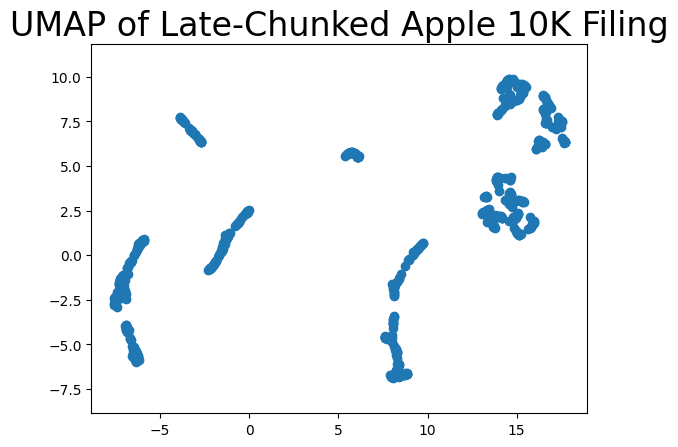

In [122]:
import matplotlib.pyplot as plt

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP of Late-Chunked Apple 10K Filing', fontsize=24);

# Conclusion

This blog post looked at how and why Late Chunking is such a powerful approach for RAG engines. We loaded up a very long document, a 120-page financial filing from Apple, and applied a sliding Late Chunking approach the embedded the entire document. We then queried the document and found a direct, relevant answer to our question. Finally, we visualized the total embeddings and can see distinct chunks for each of the document regions. 

The next post will look at how we can keep shared global context across each of the document sections. And, we'll look at a way of using the centroid of each chunk as a way to cheaply index into the most relevant document sections.